### Importação de Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importação do Dataset

In [2]:
red_wines = pd.read_csv('datasets/red_wines.csv')

In [3]:
red_wines.head(5)

,Description,Price,Alcohol,ratings_average,acidity,intensity,sweetness,tannin,vintage_ratings_average,continent,popular_wine,popular_vintage,rating_group
0,"This is a soft, richly layered and concentrate...",85.0,14.5,4.3,3.468246,3.143860,1.546160,2.078285,4.4,North America,0,0,4
1,A strong showing of black cherry and licorice ...,125.0,14.5,4.5,3.344858,4.749089,1.611013,3.312963,4.5,North America,1,0,4
2,This blended cuvée features the same attention...,52.0,14.2,4.2,3.883377,2.235860,1.453785,2.130269,4.2,North America,1,0,3
3,This stands apart from the other estate Pinots...,95.0,14.5,4.4,3.887788,2.400275,1.558072,2.328298,4.4,North America,0,0,3
4,This wine impresses immediately with its flavo...,100.0,14.4,4.3,3.627241,2.472972,1.557877,2.073915,4.5,North America,0,0,3


### Preprocessing
 1. Criação de dummies para o campo **continent**.
 2. Separação dos datasets entre treinamento e teste (train_test_split)
 3. Normalização dos valores usando StandardScaler

In [4]:
# 1
dummies = pd.get_dummies(red_wines['continent'], drop_first=True)
red_wines = pd.concat([red_wines, dummies], axis=1).drop('continent', axis=1)

In [5]:
# 2
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
description_vectorizer = vectorizer.fit_transform(red_wines['Description'])
descriptions = pd.DataFrame(description_vectorizer.toarray())

red_wines = pd.concat([red_wines, descriptions], axis=1).drop('Description', axis=1)

In [6]:
# 3
X = red_wines.drop('rating_group', axis=1)
y = red_wines['rating_group']

In [7]:
# 4
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaled_columns =['Price', 'Alcohol', 'ratings_average', 'acidity', 'intensity', 'sweetness',
                  'tannin', 'vintage_ratings_average']
X_train.loc[:, scaled_columns]= scaler.fit_transform(X_train.loc[:, scaled_columns])
X_test.loc[:, scaled_columns] = scaler.transform(X_test.loc[:, scaled_columns])

C:\Users\HAL9000\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\HAL9000\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


### Random Forest Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
base_model = RandomForestClassifier()


#### GridSearch - busca pelos melhores hiperparâmetros

In [9]:
# Parâmetros
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

param_grid = dict(n_estimators=n_estimators, max_features=max_features)

In [10]:
from sklearn.model_selection import GridSearchCV

randomforest_model = GridSearchCV(base_model,param_grid=param_grid, verbose=4)
randomforest_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............max_features=sqrt, n_estimators=10; total time=  47.1s
[CV 2/5] END .............max_features=sqrt, n_estimators=10; total time=  33.9s
[CV 3/5] END .............max_features=sqrt, n_estimators=10; total time=  32.3s
[CV 4/5] END .............max_features=sqrt, n_estimators=10; total time=  33.1s
[CV 5/5] END .............max_features=sqrt, n_estimators=10; total time=  34.3s
[CV 1/5] END ............max_features=sqrt, n_estimators=100; total time= 4.0min
[CV 2/5] END ............max_features=sqrt, n_estimators=100; total time= 4.0min
[CV 3/5] END ............max_features=sqrt, n_estimators=100; total time= 4.1min
[CV 4/5] END ............max_features=sqrt, n_estimators=100; total time= 4.1min
[CV 5/5] END ............max_features=sqrt, n_estimators=100; total time= 3.8min
[CV 1/5] END ...........max_features=sqrt, n_estimators=1000; total time=37.3min
[CV 2/5] END ...........max_features=sqrt, n_esti

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             verbose=4)

In [11]:
randomforest_model.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [12]:
# Resultados
print("Best: {} using {}".format(randomforest_model.best_score_, randomforest_model.best_params_))
means = randomforest_model.cv_results_['mean_test_score']
stds = randomforest_model.cv_results_['std_test_score']
params = randomforest_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))

Best: 0.6372168829343922 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.5855573189178467 (0.010380554885333692) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.6328430556391973 (0.00570575138375081) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.6372168829343922 (0.007984726923916892) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.561306710498815 (0.00410273488665441) with: {'max_features': 'log2', 'n_estimators': 10}
0.6195758483917782 (0.006161340983301477) with: {'max_features': 'log2', 'n_estimators': 100}
0.6275458247871272 (0.005630549189537193) with: {'max_features': 'log2', 'n_estimators': 1000}


#### Avaliação do modelo

In [13]:
y_pred = randomforest_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
train_acc = accuracy_score(y_train, randomforest_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print('Acurácia (treinamento): {}'.format(train_acc))
print('Acurácia (teste): {}'.format(test_acc))

Acurácia (treinamento): 1.0
Acurácia (teste): 0.6555164984692142


Text(0.5, 1.0, 'Matriz de confusão - Random Forest Model')

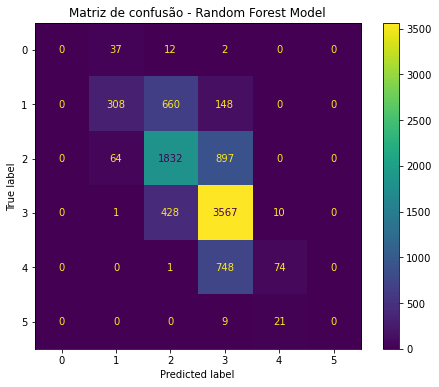

In [18]:
# Gráfico de matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(randomforest_model, X_test,y_test, ax=ax)
plt.title('Matriz de confusão - Random Forest Model')

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.75      0.28      0.40      1116
           2       0.62      0.66      0.64      2793
           3       0.66      0.89      0.76      4006
           4       0.70      0.09      0.16       823
           5       0.00      0.00      0.00        30

    accuracy                           0.66      8819
   macro avg       0.46      0.32      0.33      8819
weighted avg       0.66      0.66      0.61      8819



C:\Users\HAL9000\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HAL9000\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HAL9000\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Exportação do modelo

In [20]:
#import joblib
#joblib.dump(randomforest_model, 'models/randomforest_model.joblib')
#Ocupa muito espaço em disco (GBs)